In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from copy import deepcopy
import os

# Defines

In [2]:
# Path to the simulation output files
OUTPUT_PATH = './SimulationsPublic/'
# Names of the simulation files
testNames = ['BaselineTier0', 'ReducedNodesTier0', 'BaselineTier1', 'ReducedNodesTier1', 'BaselineTier2', 'ReducedNodesTier2', 'BaselineTier3', 'ReducedNodesTier3']
# Number of nodes used for simulating each tier 24Hs relays distribution
numberTestNodes = 1000
# Convertion of relays to POKT (from the day of the simulated data)
relay2POKT = 0.0015028
# Base stake value of a node in uPOKT
uPOKTbaseStake = 15000000000

# Empirical value of the proposed solution
K_emp = 0.86

# Number of bins for plots
binsPlots = 64
# Colors for tiers
colors = ['green', 'gold', 'orange', 'red']



In [3]:
def getPIP22multiplier(nodeStake, 
                      ValidatorStakeFloorMultiplier, 
                      ValidatorStakeWeightMultiplier, 
                      ServicerStakeWeightCeiling, 
                      ValidatorStakeFloorMultiplierExponent):
    """

    PIP-22 Multiplier calculation function.

    Parameters:
        nodeStake (float) : Stake of a given node
        ValidatorStakeFloorMultiplier (float) : Stake floor of a Pocket node in uPOKT
        ValidatorStakeWeightMultiplier (float) : Value of the weight multiplier.
        ServicerStakeWeightCeiling (float) : Maximum (usefull) stake of a Pocket node in uPOKT
        ValidatorStakeFloorMultiplierExponent (float) : Multiuplier scaling behaviour value.
    Returns:
        multiplier (float) : The multiplier that is going to be aplied to a node with the given stake amount.

    """

    # Calculate floored stake of the node
    flooredStake = np.min([nodeStake - (nodeStake % ValidatorStakeFloorMultiplier), ServicerStakeWeightCeiling])
    # Return the multiplier for this node
    return (flooredStake/ValidatorStakeFloorMultiplier)**(ValidatorStakeFloorMultiplierExponent)/(ValidatorStakeWeightMultiplier)


In [4]:
def getAvg24hsRelaysByNodeDistribution(workedRelays, numberTestNodes, binsDist=128):
    """

    Creates a histogram of relay by node for a 24hs relay simulation.

    Parameters:
        workedRelays (dict) : The relays result of sampling the sessionSampler.
        numberTestNodes (int) : Number of test nodes used during the simulation.

    Returns:
        values (np.array) : An array containing the empirical distribution of
                            relays by node.
        bines (np.array) : An array containing the bined support of the values.

    """

    # Get number of samples
    aux = list(workedRelays.items())[0][1]
    NumSamplesMC = len(list(aux.items())[0][1])

    # Get locations and chains
    testLocList = list(workedRelays.keys())
    testChainList = list()
    for idxLoc, testLoc in enumerate(testLocList):
        if workedRelays.get(testLoc, None) == None:
            continue
        for chain in workedRelays[testLoc].keys():
            if chain not in testChainList:
                testChainList.append(chain)

    # Declare 
    allRelays = np.zeros((int(NumSamplesMC)))
    # Assign
    for idxLoc, testLoc in enumerate(testLocList):
        if workedRelays.get(testLoc, None) == None:
            continue
        for idxChain, testChain in enumerate(workedRelays[testLoc].keys()):
            if len(workedRelays[testLoc].get(testChain, [])) == 0:
                continue

            # Accumulate relays here
            allRelays += workedRelays[testLoc][testChain]

    # Convert to relays by node
    allRelaysByNode = allRelays / numberTestNodes

    # Get histogram data
    values, bines = np.histogram(allRelaysByNode, bins=binsDist)

    # Calculate the empirical distribution
    values = values / values.sum()

    return values, bines


# Load and pre-compute values

In [5]:
# Load node data
nodeSelectionData  = pd.read_csv(os.path.join(OUTPUT_PATH, 'nodeSelectionDataPub.csv'), index_col=0)

In [6]:
# Get population sizes
currentPopulationSize = len(nodeSelectionData)
targetPopulationSize = len(nodeSelectionData.loc[nodeSelectionData['useNode'] == 1])

# Get current total stake and new total stake
nodeBaseStake = uPOKTbaseStake/1e9
prevStake = currentPopulationSize*nodeBaseStake
newStake = ((nodeSelectionData.loc[nodeSelectionData['useNode'] == 1]['compoundLevel']+1)*nodeBaseStake).sum()

# Get the number of base nodes (15kPOKT nodes) with the new stake
nodesBase = int(newStake/nodeBaseStake)
# Real number of nodes after compounding (equal to the target size in this case)
nodesCompound = targetPopulationSize

# Get number of compounding levels
compLevels = len(nodeSelectionData['compoundLevel'].unique())

# Get number of nodes in each level of compounding
nodesComp = np.zeros((compLevels))
for i in range(compLevels):
    aux = nodeSelectionData.loc[(nodeSelectionData['compoundLevel'] == i) & (nodeSelectionData['useNode'] == 1)]
    nodesComp[i] = len(aux)


# Run Report Calculations (not the simulations)

### Calculate PIP-22 values

In [7]:
# PUP-21 parameters:
ValidatorStakeWeightMultiplierPUP21 =  nodesBase/nodesCompound
PUP21values = (uPOKTbaseStake, ValidatorStakeWeightMultiplierPUP21, uPOKTbaseStake*4, 1.)
print('PUP-21 Parameters')
print(PUP21values)

# This is our empirical change
ValidatorStakeWeightMultiplierPROPOSED = K_emp * ValidatorStakeWeightMultiplierPUP21  
# Quickly search for a ValidatorStakeFloorMultiplierExponent value (not fancy)
bestFit = 1.0
bestError = 9e99
for value in np.linspace(1.0, 0.5, 1000):
    
    # Get this multipliers
    mults = np.zeros((4))
    for i in range(4):
        stake = (i+1)*uPOKTbaseStake
        mult = getPIP22multiplier(stake, 
                            uPOKTbaseStake, 
                            ValidatorStakeWeightMultiplierPROPOSED, 
                            uPOKTbaseStake*4, 
                            value)
        mults[i] = mult
    # Calculate the error against the unity (see equation 9 of the report)
    error = np.abs(1-(np.array(nodesComp*mults)).sum()/nodesCompound)
    # Keep lowers error
    if error < bestError:
        bestFit = value
        bestError = error

# Porposed values, non-linear
PROPOSEDvalues = (uPOKTbaseStake, ValidatorStakeWeightMultiplierPROPOSED, uPOKTbaseStake*4, bestFit)
print('Proposed Parameters')
print(PROPOSEDvalues)

PUP-21 Parameters
(15000000000, 1.986, 60000000000, 1.0)
Proposed Parameters
(15000000000, 1.70796, 60000000000, 0.8228228228228228)


In [8]:
# Calculate and present multipliers

print('PUP-21 multipliers:')
settingsUSE = PUP21values
for i in range(4):
    stake = (i+1)*uPOKTbaseStake
    mult = getPIP22multiplier(stake, 
                        settingsUSE[0], 
                        settingsUSE[1], 
                        settingsUSE[2], 
                        settingsUSE[3])
    print('%d kPOKT -> %0.2f'%(stake/1e9, mult))

print('\nProposed multipliers:')
settingsUSE = PROPOSEDvalues
for i in range(4):
    stake = (i+1)*uPOKTbaseStake
    mult = getPIP22multiplier(stake, 
                        settingsUSE[0], 
                        settingsUSE[1], 
                        settingsUSE[2], 
                        settingsUSE[3])
    print('%d kPOKT -> %0.2f'%(stake/1e9, mult))

PUP-21 multipliers:
15 kPOKT -> 0.50
30 kPOKT -> 1.01
45 kPOKT -> 1.51
60 kPOKT -> 2.01

Proposed multipliers:
15 kPOKT -> 0.59
30 kPOKT -> 1.04
45 kPOKT -> 1.45
60 kPOKT -> 1.83


### Check Minting Values

In [9]:
# To estimate the total minting we will use the minting distribution on each tier
# and the number of nodes by tier multiplies by their stake weighting multiplier

numSamplesComp = 100

# Create variables
workedRelays24HsBaseline = np.zeros((numSamplesComp))
mintedPokt24HsBaseline = np.zeros((numSamplesComp))
workedRelays24HsCompounded = np.zeros((numSamplesComp))
mintedPokt24HsCompoundedPUP21 = np.zeros((numSamplesComp))
mintedPokt24HsCompoundedPROPOSED = np.zeros((numSamplesComp))


for idxSample in range(numSamplesComp):

    # Baseline
    for i in range(4):

        # Get the number of nodes in this tier
        numNodes = len(nodeSelectionData.loc[(nodeSelectionData['node Tier'] == i)])

        # Load simulation
        testName = 'BaselineTier%d'%i
        in_file = open(os.path.join(OUTPUT_PATH, testName+'_workedRelays'+'.pkl'), "rb")
        workedRelays = pickle.load(in_file)
        in_file.close()

        # Get the expected relays distribution in 24hs here
        allRelays, bines = getAvg24hsRelaysByNodeDistribution(workedRelays, numberTestNodes, binsDist = 128)

        # Pick
        chosenRelays = np.random.choice(bines[:-1], size=numNodes, p=allRelays)

        # Add up
        workedRelays24HsBaseline[idxSample] += chosenRelays.sum()
        mintedPokt24HsBaseline[idxSample] += chosenRelays.sum()*relay2POKT

    # PIP-22
    for i in range(4):

        # Get dataframe slice
        auxDF = nodeSelectionData.loc[(nodeSelectionData['node Tier'] == i) & (nodeSelectionData['useNode'] == 1)]
        # Get the mnumber of nodes in this tier
        numNodes = len(auxDF)
        # Get compound level
        settingsUSE = PUP21values
        compoundingPUP21 = auxDF['compoundLevel'].apply(lambda x : getPIP22multiplier((x+1)*uPOKTbaseStake, 
                                                                                 settingsUSE[0], 
                                                                                 settingsUSE[1], 
                                                                                 settingsUSE[2], 
                                                                                 settingsUSE[3])).values
        settingsUSE = PROPOSEDvalues
        compoundingPROPOSED = auxDF['compoundLevel'].apply(lambda x : getPIP22multiplier((x+1)*uPOKTbaseStake, 
                                                                                 settingsUSE[0], 
                                                                                 settingsUSE[1], 
                                                                                 settingsUSE[2], 
                                                                                 settingsUSE[3])).values
                                                                                 

        # Load simulation
        testName = 'ReducedNodesTier%d'%i
        in_file = open(os.path.join(OUTPUT_PATH, testName+'_workedRelays'+'.pkl'), "rb")
        workedRelays = pickle.load(in_file)
        in_file.close()
        
        # Get the expected relays distribution in 24hs here
        allRelays, bines = getAvg24hsRelaysByNodeDistribution(workedRelays, numberTestNodes, binsDist = 128)

        # Pick
        chosenRelays = np.random.choice(bines[:-1], size=numNodes, p=allRelays)

        # Add up
        workedRelays24HsCompounded[idxSample] += chosenRelays.sum()
        mintedPokt24HsCompoundedPUP21[idxSample] += (chosenRelays*compoundingPUP21).sum()*relay2POKT
        mintedPokt24HsCompoundedPROPOSED[idxSample] += (chosenRelays*compoundingPROPOSED).sum()*relay2POKT



In [10]:

print('Relays (simulated networks)')
print('\tCurrent : %g\n\tReduced : %g'%(workedRelays24HsBaseline.mean(), workedRelays24HsCompounded.mean()))
print('\tDifference : %g %%'% ((workedRelays24HsCompounded.mean()-workedRelays24HsBaseline.mean())*100./workedRelays24HsBaseline.mean()))
print('Total POKT minted (current state, prior PIP-22)')
print('\t %g'%(mintedPokt24HsBaseline.mean()))
print('Total POKT minted (PUP-21 Values)')
print('\t %g'%(mintedPokt24HsCompoundedPUP21.mean()))
print('\tDifference : %g %%'% ((mintedPokt24HsCompoundedPUP21.mean()-mintedPokt24HsBaseline.mean())*100./mintedPokt24HsBaseline.mean()))
print('Total POKT minted (Proposed Values):')
print('\t %g'%(mintedPokt24HsCompoundedPROPOSED.mean()))
print('\tDifference : %g %%'% ((mintedPokt24HsCompoundedPROPOSED.mean()-mintedPokt24HsBaseline.mean())*100./mintedPokt24HsBaseline.mean()))


Relays (simulated networks)
	Current : 6.38431e+08
	Reduced : 6.38961e+08
	Difference : 0.0830683 %
Total POKT minted (current state, prior PIP-22)
	 959434
Total POKT minted (PUP-21 Values)
	 960698
	Difference : 0.131759 %
Total POKT minted (Proposed Values):
	 960735
	Difference : 0.135534 %


# Plots

### Reduced Nodes Network

Mean Values:
BaselineTier0 : 38.16
BaselineTier1 : 27.74
BaselineTier2 : 26.97
BaselineTier3 : 25.67
ReducedNodesTier0 : 65.27
ReducedNodesTier1 : 47.24
ReducedNodesTier2 : 46.16
ReducedNodesTier3 : 44.25


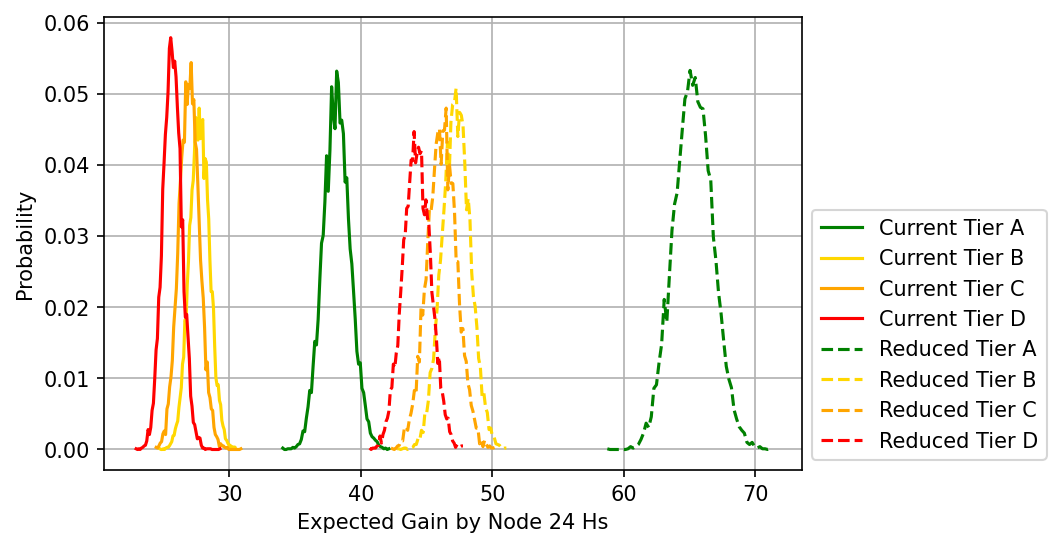

In [11]:
plt.figure(dpi=150)

print('Mean Values:')

legendList = list()
for testName in testNames:

    if 'Baseline' in testName:
        legendList.append(testName)

        # Load 
        in_file = open(os.path.join(OUTPUT_PATH, testName+'_workedRelays'+'.pkl'), "rb")
        workedRelays = pickle.load(in_file)
        in_file.close()

        allRelays, bines = getAvg24hsRelaysByNodeDistribution(workedRelays, numberTestNodes, binsDist = binsPlots)

        bines = bines*relay2POKT

        
        plt.plot(bines[:-1], allRelays, colors[len(legendList)-1])

        thisMean = (np.sum(bines[:-1]*allRelays))/allRelays.sum()
        print('%s : %0.2f'%(testName, thisMean))


legendList = list()
for testName in testNames:

    if 'Reduced' in testName:
        legendList.append(testName)

        # Load 
        in_file = open(os.path.join(OUTPUT_PATH, testName+'_workedRelays'+'.pkl'), "rb")
        workedRelays = pickle.load(in_file)
        in_file.close()

        allRelays, bines = getAvg24hsRelaysByNodeDistribution(workedRelays, numberTestNodes, binsDist = binsPlots)

        bines = bines*relay2POKT

        
        plt.plot(bines[:-1], allRelays, color=colors[len(legendList)-1], ls='--')

        thisMean = (np.sum(bines[:-1]*allRelays))/allRelays.sum()
        print('%s : %0.2f'%(testName, thisMean))


plt.grid()
plt.ylabel('Probability')
plt.xlabel('Expected Gain by Node 24 Hs')
plt.legend(['Current Tier A',  'Current Tier B', 'Current Tier C', 'Current Tier D', 'Reduced Tier A',  'Reduced Tier B', 'Reduced Tier C', 'Reduced Tier D'], 
        bbox_to_anchor=(1,0), 
        loc="lower left")
plt.show()


    
    

### PUP-21 Parameters

Mean Values:
BaselineTier0 : 38.16
BaselineTier1 : 27.74
BaselineTier2 : 26.97
BaselineTier3 : 25.67
ReducedNodesTier0 : 32.86
ReducedNodesTier1 : 23.79
ReducedNodesTier2 : 23.24
ReducedNodesTier3 : 22.28


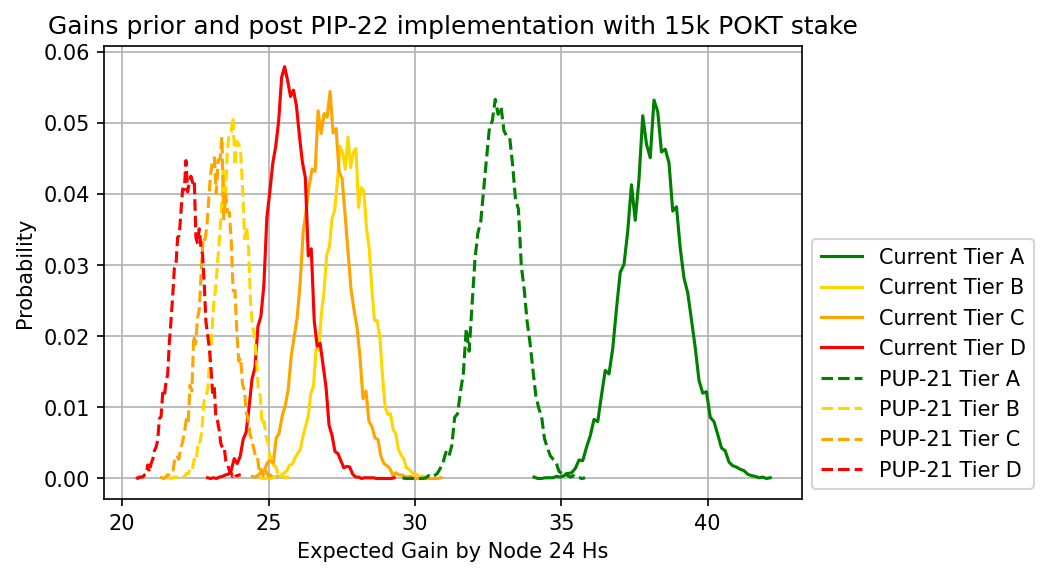

In [12]:
plt.figure(dpi=150)

print('Mean Values:')


legendList = list()
settingsUSE = PUP21values
for testName in testNames:

    if 'Baseline' in testName:
        legendList.append(testName)

        # Load 
        in_file = open(os.path.join(OUTPUT_PATH, testName+'_workedRelays'+'.pkl'), "rb")
        workedRelays = pickle.load(in_file)
        in_file.close()

        allRelays, bines = getAvg24hsRelaysByNodeDistribution(workedRelays, numberTestNodes, binsDist = binsPlots)

        bines = bines*relay2POKT

        thisMean = (np.sum(bines[:-1]*allRelays))/allRelays.sum()
        print('%s : %0.2f'%(testName, thisMean))

        
        plt.plot(bines[:-1], allRelays, colors[len(legendList)-1])

# Plot non-compounding distributions
stake = uPOKTbaseStake
mult = getPIP22multiplier(stake, 
                    settingsUSE[0], 
                    settingsUSE[1], 
                    settingsUSE[2], 
                    settingsUSE[3])

legendList = list()
for testName in testNames:

    if 'Reduced' in testName:
        legendList.append(testName)

        # Load 
        in_file = open(os.path.join(OUTPUT_PATH, testName+'_workedRelays'+'.pkl'), "rb")
        workedRelays = pickle.load(in_file)
        in_file.close()

        allRelays, bines = getAvg24hsRelaysByNodeDistribution(workedRelays, numberTestNodes, binsDist = binsPlots)

        bines = bines*relay2POKT*mult

        thisMean = (np.sum(bines[:-1]*allRelays))/allRelays.sum()
        print('%s : %0.2f'%(testName, thisMean))

        
        plt.plot(bines[:-1], allRelays, color=colors[len(legendList)-1], ls='--')


plt.grid()
plt.title('Gains prior and post PIP-22 implementation with 15k POKT stake')
plt.ylabel('Probability')
plt.xlabel('Expected Gain by Node 24 Hs')
plt.legend(['Current Tier A',  'Current Tier B', 'Current Tier C', 'Current Tier D', 'PUP-21 Tier A',  'PUP-21 Tier B', 'PUP-21 Tier C', 'PUP-21 Tier D'],
bbox_to_anchor=(1,0), 
        loc="lower left")
plt.show()
    
    

### Proposed Parameters

BaselineTier0 : 38.16
BaselineTier1 : 27.74
BaselineTier2 : 26.97
BaselineTier3 : 25.67
ReducedNodesTier0 : 38.21
ReducedNodesTier1 : 27.66
ReducedNodesTier2 : 27.03
ReducedNodesTier3 : 25.91


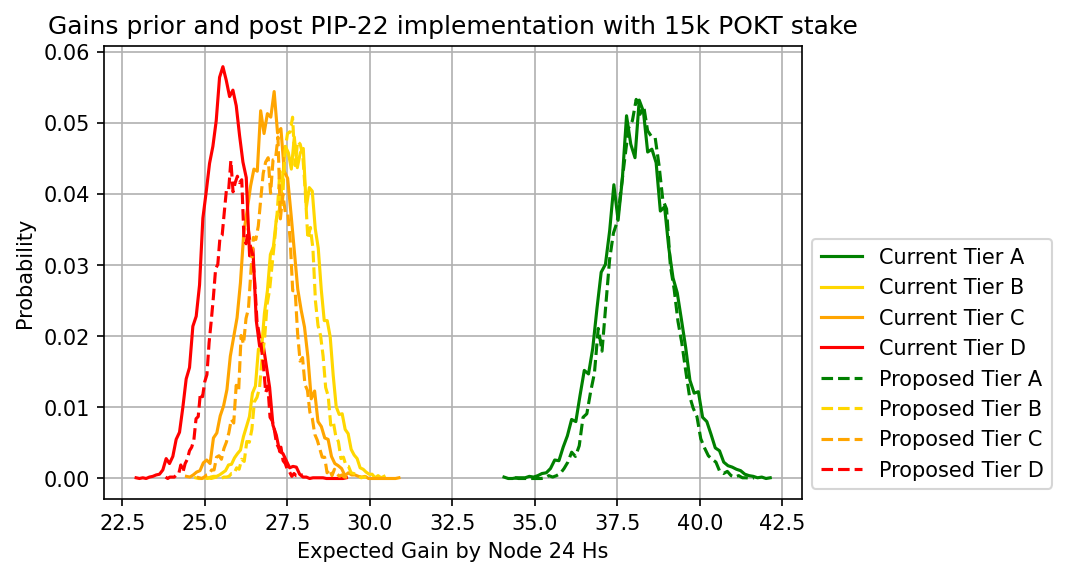

In [13]:
plt.figure(dpi=150)

legendList = list()
settingsUSE = PROPOSEDvalues
for testName in testNames:

    if 'Baseline' in testName:
        legendList.append(testName)

        # Load 
        in_file = open(os.path.join(OUTPUT_PATH, testName+'_workedRelays'+'.pkl'), "rb")
        workedRelays = pickle.load(in_file)
        in_file.close()

        allRelays, bines = getAvg24hsRelaysByNodeDistribution(workedRelays, numberTestNodes, binsDist = binsPlots)

        bines = bines*relay2POKT

        thisMean = (np.sum(bines[:-1]*allRelays))/allRelays.sum()
        print('%s : %0.2f'%(testName, thisMean))

        
        plt.plot(bines[:-1], allRelays, colors[len(legendList)-1])

# Plot non-compounding distributions
stake = uPOKTbaseStake
mult = getPIP22multiplier(stake, 
                    settingsUSE[0], 
                    settingsUSE[1], 
                    settingsUSE[2], 
                    settingsUSE[3])

legendList = list()
for testName in testNames:

    if 'Reduced' in testName:
        legendList.append(testName)

        # Load 
        in_file = open(os.path.join(OUTPUT_PATH, testName+'_workedRelays'+'.pkl'), "rb")
        workedRelays = pickle.load(in_file)
        in_file.close()

        allRelays, bines = getAvg24hsRelaysByNodeDistribution(workedRelays, numberTestNodes, binsDist = binsPlots)

        bines = bines*relay2POKT*mult

        thisMean = (np.sum(bines[:-1]*allRelays))/allRelays.sum()
        print('%s : %0.2f'%(testName, thisMean))

        
        plt.plot(bines[:-1], allRelays, color=colors[len(legendList)-1], ls='--')


plt.grid()
plt.title('Gains prior and post PIP-22 implementation with 15k POKT stake')
plt.ylabel('Probability')
plt.xlabel('Expected Gain by Node 24 Hs')
plt.legend(['Current Tier A',  'Current Tier B', 'Current Tier C', 'Current Tier D', 'Proposed Tier A',  'Proposed Tier B', 'Proposed Tier C', 'Proposed Tier D'],
bbox_to_anchor=(1,0), 
        loc="lower left")
plt.show()
    
    

### Other Plots not present in Report

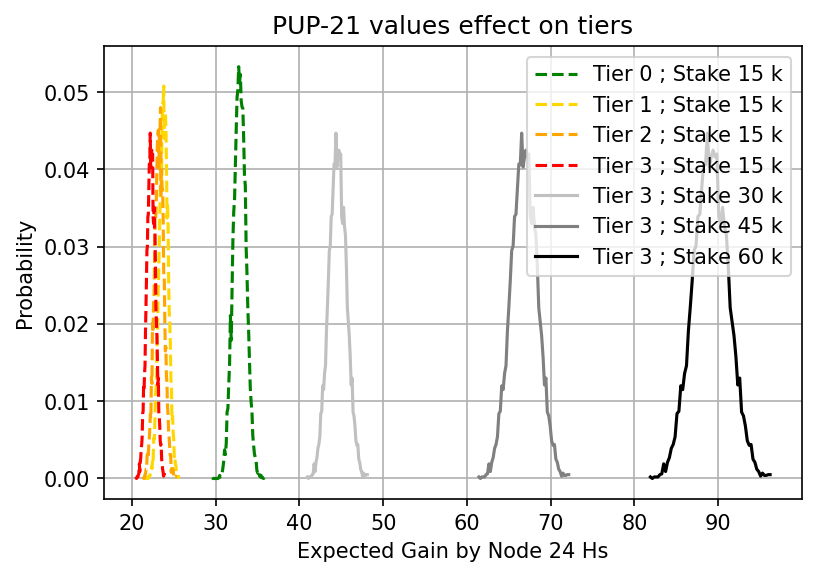

In [14]:
nodeTier = 3
settingsUSE = PUP21values

colors = ['green', 'gold', 'orange', 'red', 'silver', 'grey', 'black']

plt.figure(dpi=150)
legendList = list()


# Plot non-compounding distributions
stake = uPOKTbaseStake
mult = getPIP22multiplier(stake, 
                    settingsUSE[0], 
                    settingsUSE[1], 
                    settingsUSE[2], 
                    settingsUSE[3])


for testName in testNames:

    if 'ReducedNodes' in testName:
        
        legendList.append('Tier %s ; Stake %d k'%(testName.split('ReducedNodesTier')[-1], stake/1e9))

        # Load 
        in_file = open(os.path.join(OUTPUT_PATH, testName+'_workedRelays'+'.pkl'), "rb")
        workedRelays = pickle.load(in_file)
        in_file.close()

        allRelays, bines = getAvg24hsRelaysByNodeDistribution(workedRelays, numberTestNodes, binsDist = binsPlots)

        bines = bines*relay2POKT*mult

        
        plt.plot(bines[:-1], allRelays, colors[len(legendList)-1], ls='--')




# Load simulation
testName = 'ReducedNodesTier%d'%nodeTier
in_file = open(os.path.join(OUTPUT_PATH, testName+'_workedRelays'+'.pkl'), "rb")
workedRelays = pickle.load(in_file)
in_file.close()

allRelays, bines = getAvg24hsRelaysByNodeDistribution(workedRelays, numberTestNodes, binsDist = binsPlots)

for i in range(3):
    stake = (i+2)*uPOKTbaseStake
    mult = getPIP22multiplier(stake, 
                        settingsUSE[0], 
                        settingsUSE[1], 
                        settingsUSE[2], 
                        settingsUSE[3])

    legendList.append('Tier %d ; Stake %d k'%(nodeTier, stake/1e9))

    binesAux = deepcopy(bines)*relay2POKT*mult

    plt.plot(binesAux[:-1], allRelays, colors[len(legendList)-1])




plt.title('PUP-21 values effect on tiers')
plt.grid()
plt.ylabel('Probability')
plt.xlabel('Expected Gain by Node 24 Hs')
plt.legend(legendList)
plt.show()
    
    

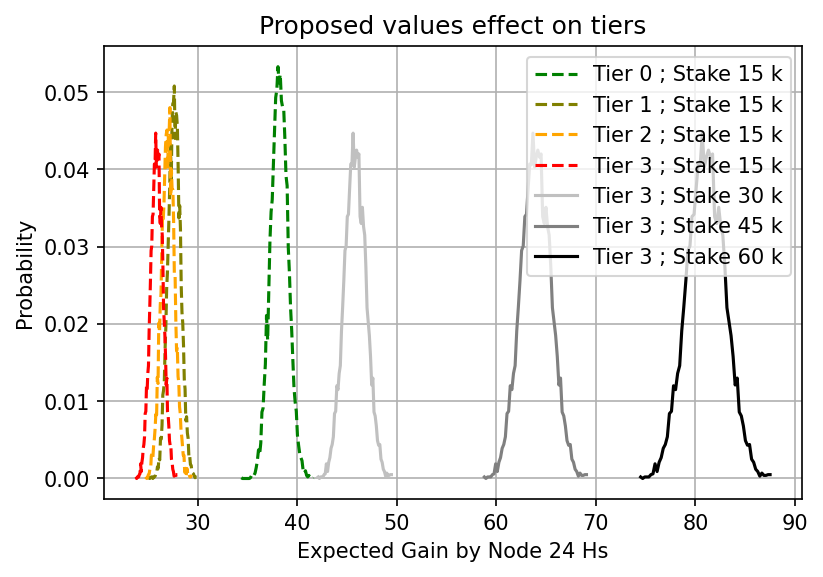

In [15]:
nodeTier = 3
settingsUSE = PROPOSEDvalues

colors = ['green', 'olive', 'orange', 'red', 'silver', 'grey', 'black']

plt.figure(dpi=150)
legendList = list()


# Plot non-compounding distributions
stake = uPOKTbaseStake
mult = getPIP22multiplier(stake, 
                    settingsUSE[0], 
                    settingsUSE[1], 
                    settingsUSE[2], 
                    settingsUSE[3])


for testName in testNames:

    if 'ReducedNodes' in testName:
        
        legendList.append('Tier %s ; Stake %d k'%(testName.split('ReducedNodesTier')[-1], stake/1e9))

        # Load 
        in_file = open(os.path.join(OUTPUT_PATH, testName+'_workedRelays'+'.pkl'), "rb")
        workedRelays = pickle.load(in_file)
        in_file.close()

        allRelays, bines = getAvg24hsRelaysByNodeDistribution(workedRelays, numberTestNodes, binsDist = binsPlots)

        bines = bines*relay2POKT*mult

        
        plt.plot(bines[:-1], allRelays, colors[len(legendList)-1], ls='--')




# Load simulation
testName = 'ReducedNodesTier%d'%nodeTier
in_file = open(os.path.join(OUTPUT_PATH, testName+'_workedRelays'+'.pkl'), "rb")
workedRelays = pickle.load(in_file)
in_file.close()

allRelays, bines = getAvg24hsRelaysByNodeDistribution(workedRelays, numberTestNodes, binsDist = binsPlots)

for i in range(3):
    stake = (i+2)*uPOKTbaseStake
    mult = getPIP22multiplier(stake, 
                        settingsUSE[0], 
                        settingsUSE[1], 
                        settingsUSE[2], 
                        settingsUSE[3])

    legendList.append('Tier %d ; Stake %d k'%(nodeTier, stake/1e9))

    binesAux = deepcopy(bines)*relay2POKT*mult

    plt.plot(binesAux[:-1], allRelays, colors[len(legendList)-1])




plt.title('Proposed values effect on tiers')
plt.grid()
plt.ylabel('Probability')
plt.xlabel('Expected Gain by Node 24 Hs')
plt.legend(legendList)
plt.show()
    
    